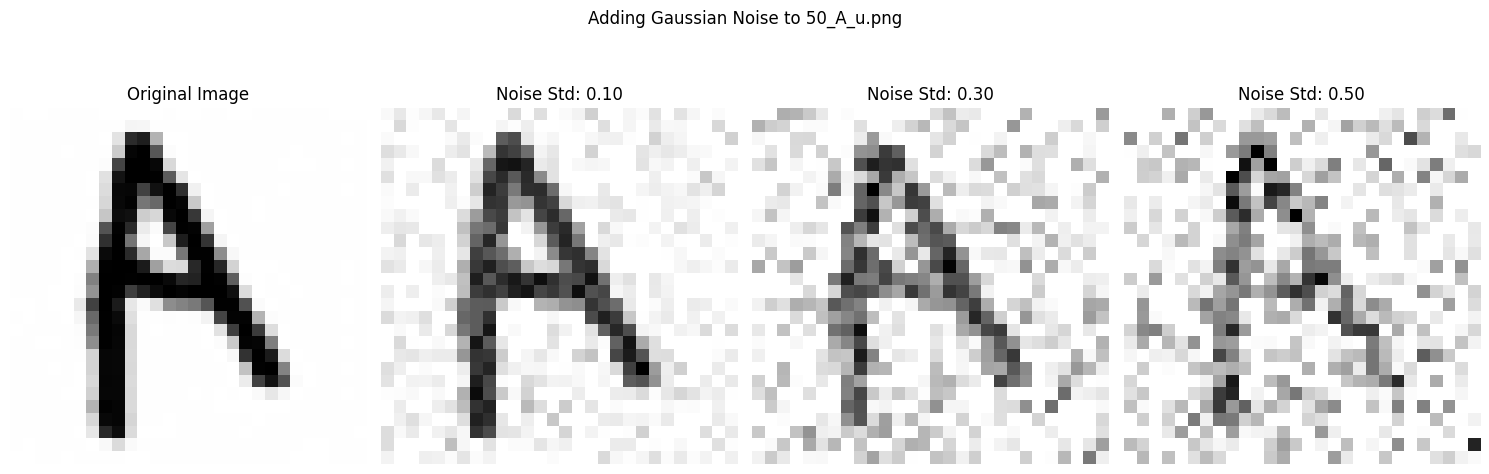

In [3]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def visualize_noise_on_image(image_path, num_noise_levels=3):
    """Loads an image, adds varying levels of Gaussian noise, and visualizes the results."""
    try:
        original_image = Image.open(image_path).convert('L')  # Load as grayscale
        transform = transforms.ToTensor()
        original_tensor = transform(original_image).unsqueeze(0) # Add batch dimension

        fig, axes = plt.subplots(1, num_noise_levels + 1, figsize=(15, 5))
        axes[0].imshow(original_tensor[0][0], cmap='gray')
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        for i in range(num_noise_levels):
            std = 0.1 + i * 0.2
            noise = torch.randn_like(original_tensor) * std
            noisy_image = original_tensor + noise
            noisy_image = torch.clamp(noisy_image, -1, 1) # Clamp to the typical image range

            axes[i + 1].imshow(noisy_image[0][0], cmap='gray')
            axes[i + 1].set_title(f"Noise Std: {std:.2f}")
            axes[i + 1].axis('off')

        plt.suptitle(f"Adding Gaussian Noise to {image_path.split('/')[-1]}", y=1.02)
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Error: The image file '{image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Specify the path to your image file
image_file_path = "letters/50_A_u.png" # Adjust epoch number if needed

visualize_noise_on_image(image_file_path)

In [1]:
import torch
from torchviz import make_dot
from diffusers import UNet2DModel

num_classes = 52  # Assuming you have 52 classes

model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
    class_embed_type="timestep",
    num_class_embeds=num_classes,
)

# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 28, 28)
dummy_timestep = torch.randint(0, 1000, (1,))
dummy_labels = torch.randint(0, num_classes, (1,))

# Get the output of the model with the dummy input
y = model(dummy_input, dummy_timestep, dummy_labels).sample

# Create the visualization
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("unet_model_graph", view=True) # Saves as unet_model_graph.pdf and opens it

'unet_model_graph.pdf'

In [2]:
import torch
import torch.onnx
from diffusers import UNet2DModel

num_classes = 52  # Assuming you have 52 classes

model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
    class_embed_type="timestep",
    num_class_embeds=num_classes,
)

# Create dummy inputs
dummy_input = torch.randn(1, 1, 28, 28, requires_grad=True)
dummy_timestep = torch.randint(0, 1000, (1,), requires_grad=False).long()
dummy_labels = torch.randint(0, num_classes, (1,), requires_grad=False).long()

# Export to ONNX
torch.onnx.export(model,
                  (dummy_input, dummy_timestep, dummy_labels),
                  "unet_model.onnx",
                  export_params=True,
                  opset_version=15,
                  do_constant_folding=True,
                  input_names=['input', 'timestep', 'labels'],
                  output_names=['output'])

print("UNet model exported to unet_model.onnx")

d:\python\Lib\site-packages\diffusers\models\downsampling.py:136: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
d:\python\Lib\site-packages\diffusers\models\downsampling.py:145: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape[1] == self.channels
d:\python\Lib\site-packages\diffusers\models\upsampling.py:147: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a

OnnxExporterError: Module onnx is not installed!

Checkpoint at epoch 50 loaded successfully!
Generating first set of samples:
Initial Noise (First Sample): [ 1.034582    0.2906968   0.26383665 -0.85906416 -0.3526916 ]


Sampling: 0it [00:00, ?it/s]

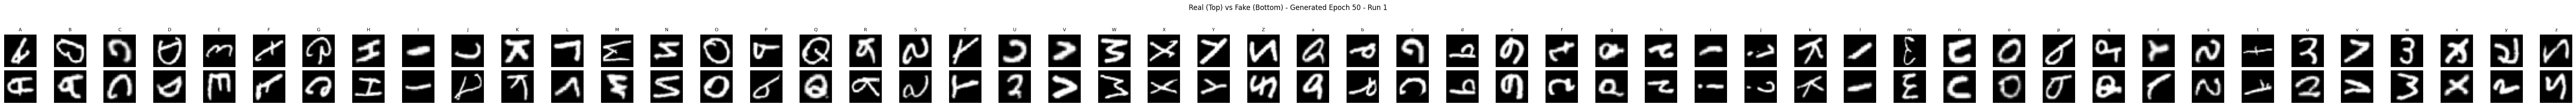


Generated samples saved to emnist_diffusion_model/generated_epoch_50_run1/

Generating second set of samples:
Initial Noise (First Sample): [-0.7833914   0.32072383  1.0439155  -1.455811    0.12050544]


Sampling: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.datasets import EMNIST
from torchvision import transforms
from diffusers import UNet2DModel, DDPMScheduler
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
from tqdm.auto import tqdm

# === 1. Dataset Setup ===

class RemapLabels(Dataset):
    def __init__(self, subset, label_map):
        self.subset = subset
        self.label_map = label_map

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.label_map[y]

    def __len__(self):
        return len(self.subset)


def get_letter_emnist_dataset():
    full_dataset = EMNIST(
        "./data",
        split="byclass",
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    )

    valid_labels = list(range(10, 62))  # A-Z (10-35), a-z (36-61)
    indices = [i for i, (_, label) in enumerate(full_dataset) if label in valid_labels]
    label_map = {orig: new for new, orig in enumerate(valid_labels)}
    subset = Subset(full_dataset, indices)

    return RemapLabels(subset, label_map), [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]


dataset, class_labels = get_letter_emnist_dataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0) # Shuffle False for ordered real images
num_classes = len(class_labels)

# === 2. Model Configuration (must match training) ===

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0001,
    beta_end=0.02
)

model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # Increased layers per block
    block_out_channels=(32, 64, 128),  # Increased number of channels and depth
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
    class_embed_type="timestep",
    num_class_embeds=num_classes,
)

# === 3. Accelerator Setup ===

accelerator = Accelerator(
    mixed_precision="fp16",
    device_placement=torch.cuda.is_available() # Only place on GPU if available
)

model = accelerator.prepare(model)

# === 4. Load Checkpoint ===

checkpoint_path = "emnist_diffusion_model/epoch_50"
if os.path.exists(checkpoint_path):
    accelerator.load_state(checkpoint_path)
    print(f"Checkpoint at epoch 50 loaded successfully!")
else:
    print(f"No checkpoint found at {checkpoint_path}, please ensure the path is correct.")
    exit()

# === 5. Sampling Function ===

def generate_all_class_samples(model, scheduler, num_classes, device):
    model.eval()
    all_labels = torch.arange(num_classes, device=device)
    noise = torch.randn((num_classes, 1, 28, 28), device=device) # Random noise initialization
    print("Initial Noise (First Sample):", noise[0, 0, 0, :5].cpu().numpy()) # Debugging

    for t in tqdm(reversed(range(scheduler.num_train_timesteps)), desc="Sampling"):
        t_batch = torch.full((num_classes,), t, device=device)
        with torch.no_grad():
            noise_pred = model(noise, t_batch, all_labels).sample
        noise = scheduler.step(noise_pred, t, noise).prev_sample

    images = (noise.clamp(-1, 1) + 1) * 0.5
    return images, all_labels

# === 6. Get Ordered Real Images ===

def get_label_ordered_real_images(dataloader, num_classes):
    ordered = {}
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()
            if label not in ordered:
                ordered[label] = img
            if len(ordered) == num_classes:
                break
        if len(ordered) == num_classes:
            break

    ordered_images = [ordered[i] for i in range(num_classes)]
    return torch.stack(ordered_images)

# === 7. Show Label Aligned Images ===

def show_label_aligned_images(fake_images, fake_labels, real_images, class_labels, epoch_tag="Generated Epoch 50"):
    num_classes = len(class_labels)

    fig, axes = plt.subplots(2, num_classes, figsize=(num_classes * 1.2, 2.4))
    for i in range(num_classes):
        # Show real image
        axes[0, i].imshow(real_images[i][0].cpu(), cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title(class_labels[i], fontsize=8)

        # Show fake image (same index since they're label-aligned)
        axes[1, i].imshow(fake_images[i][0].cpu(), cmap="gray")
        axes[1, i].axis("off")

    plt.suptitle(f"Real (Top) vs Fake (Bottom) - {epoch_tag}", y=1.05)
    plt.tight_layout()
    plt.show()

# === 8. Save Individual Samples ===

def save_individual_samples(fake_images, fake_labels, class_labels, epoch="50_loaded"):
    os.makedirs(f"emnist_diffusion_model/generated_epoch_{epoch}", exist_ok=True)

    for i, (img, label_tensor) in enumerate(zip(fake_images, fake_labels)):
        label = label_tensor.item()
        char = class_labels[label]
        case = 'u' if char.isupper() else 'l'
        filename = f"emnist_diffusion_model/generated_epoch_{epoch}/{epoch}_{char}_{case}.png"

        img_pil = transforms.ToPILImage()(img.cpu())
        img_pil.save(filename)
    print(f"\nGenerated samples saved to emnist_diffusion_model/generated_epoch_{epoch}/")



if __name__ == "__main__":
  
    device = accelerator.device
    model_eval = accelerator.unwrap_model(model).to(device)

    print("Generating first set of samples:")
    fake_images_run1, fake_labels_run1 = generate_all_class_samples(model_eval, noise_scheduler, num_classes, device)
    real_images_ordered = get_label_ordered_real_images(dataloader, num_classes)
    show_label_aligned_images(fake_images_run1, fake_labels_run1, real_images_ordered.cpu(), class_labels, epoch_tag="Generated Epoch 50 - Run 1")
    save_individual_samples(fake_images_run1, fake_labels_run1, class_labels, epoch="50_run1")

    


--- Evaluating Checkpoint at Epoch 50 (1 random-seed run) ---
Checkpoint at epoch 50 loaded successfully!

--- Random Seed for this run: 23 ---


Sampling: 0it [00:00, ?it/s]

[Epoch 50] Seed: 23, SSIM: 0.3741, FID: 0.0054, IS: 1.7646


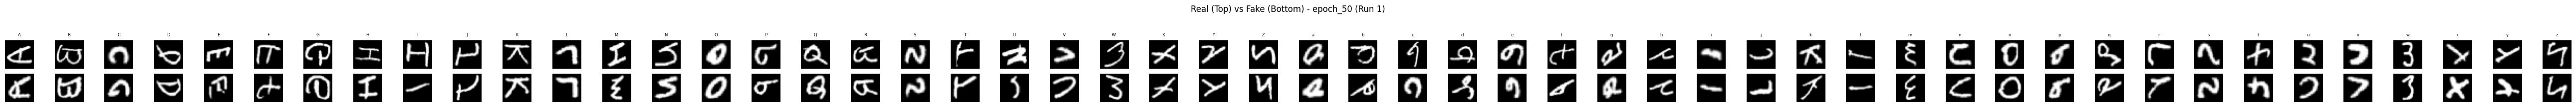

Label-aligned samples for epoch_50, run 1 saved to emnist_evaluation_epoch_50_random_seed/label_aligned_samples_epoch_50_run_1.png.
Evaluation for epoch 50 completed.


In [10]:
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.datasets import EMNIST
from torchvision import transforms
from diffusers import UNet2DModel, DDPMScheduler
from accelerate import Accelerator
from PIL import Image
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torch.nn.functional as F
from tqdm.auto import tqdm
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# === 1. Set Current Epoch ===
current_epoch = 50 # Set the epoch you want to evaluate

# === 2. Dataset Setup ===
class RemapLabels(Dataset):
    def __init__(self, subset, label_map):
        self.subset = subset
        self.label_map = label_map

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.label_map[y]

    def __len__(self):
        return len(self.subset)

def get_letter_emnist_dataset():
    full_dataset = EMNIST(
        "./data",
        split="byclass",
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    )
    valid_labels = list(range(10, 62))  # A-Z (10-35), a-z (36-61)
    indices = [i for i, (_, label) in enumerate(full_dataset) if label in valid_labels]
    label_map = {orig: new for new, orig in enumerate(valid_labels)}
    subset = Subset(full_dataset, indices)
    return RemapLabels(subset, label_map), [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

dataset, class_labels = get_letter_emnist_dataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
num_classes = len(class_labels)

# Output folder
output_dir = f"emnist_evaluation_epoch_{current_epoch}_random_seed"
os.makedirs(output_dir, exist_ok=True)

with open(f"{output_dir}/class_map.json", "w") as f:
    json.dump(class_labels, f)

# === 3. Model Configuration ===
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0001,
    beta_end=0.02
)
base_model_config = {
    "sample_size": 28,
    "in_channels": 1,
    "out_channels": 1,
    "layers_per_block": 2,
    "block_out_channels": (32, 64, 128),
    "down_block_types": ("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    "up_block_types": ("UpBlock2D", "UpBlock2D", "UpBlock2D"),
    "class_embed_type": "timestep",
    "num_class_embeds": num_classes,
}
def create_model(config):
    return UNet2DModel(**config)

# === 4. Accelerator Setup ===
accelerator = Accelerator(mixed_precision="fp16")
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(accelerator.device)
fid_metric = FrechetInceptionDistance(feature=64).to(accelerator.device)
is_metric = InceptionScore().to(accelerator.device)

# === Helper Functions ===
def generate_batch_samples(model, scheduler, num_classes, device):
    model.eval()
    all_labels = torch.arange(num_classes, device=device)
    noise = torch.randn((num_classes, 1, 28, 28), device=device)
    for t in tqdm(reversed(range(scheduler.num_train_timesteps)), desc="Sampling"):
        t_batch = torch.full((num_classes,), t, device=device)
        with torch.no_grad():
            noise_pred = model(noise, t_batch, all_labels).sample
        noise = scheduler.step(noise_pred, t, noise).prev_sample
    images = (noise.clamp(-1, 1) + 1) * 0.5
    return images, all_labels

def get_label_ordered_real_images(dataloader, num_classes, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    ordered = {}
    data_iter = iter(dataloader)
    while len(ordered) < num_classes:
        try:
            images, labels = next(data_iter)
            for img, label in zip(images, labels):
                label = label.item()
                if label not in ordered:
                    ordered[label] = img
                    if len(ordered) == num_classes:
                        break
        except StopIteration:
            data_iter = iter(dataloader)
    ordered_images = [ordered[i] for i in range(num_classes)]
    return torch.stack(ordered_images)

def show_label_aligned_images(fake_images, fake_labels, real_images, class_labels, run, epoch_tag="epoch_10"):
    num_classes = len(class_labels)
    fig, axes = plt.subplots(2, num_classes, figsize=(num_classes, 2))
    for i in range(num_classes):
        axes[0, i].imshow(real_images[i][0].cpu(), cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title(class_labels[i], fontsize=6)

        axes[1, i].imshow(fake_images[i][0].cpu(), cmap="gray")
        axes[1, i].axis("off")

    plt.suptitle(f"Real (Top) vs Fake (Bottom) - {epoch_tag} (Run {run})", y=1.05)
    plt.tight_layout()
    filename = f"{output_dir}/label_aligned_samples_{epoch_tag}_run_{run}.png"
    plt.savefig(filename)
    plt.show()
    print(f"Label-aligned samples for {epoch_tag}, run {run} saved to {filename}.")

def save_individual_samples(fake_images, fake_labels, class_labels, epoch, run, output_dir):
    os.makedirs(f"{output_dir}/run_{run}", exist_ok=True)
    for img, label in zip(fake_images, fake_labels):
        label = label.item()
        char = class_labels[label]
        case = 'u' if char.isupper() else 'l'
        filename = f"{output_dir}/run_{run}/{epoch}_{char}_{case}.png"
        img_pil = transforms.ToPILImage()(img.cpu())
        img_pil.save(filename)

def evaluate_metrics(fake_images, fake_labels, real_images, ssim_metric, fid_metric, is_metric, device):
    real_images = (real_images + 1) / 2.0
    if real_images.ndim == 3:
        real_images = real_images[:, None]
    if fake_images.ndim == 3:
        fake_images = fake_images[:, None]
    ssim_score = ssim_metric(fake_images.to(device), real_images.to(device)).item()
    fake_images_metric = preprocess_for_metrics(fake_images)
    real_images_metric = preprocess_for_metrics(real_images)
    fid_metric.reset()
    is_metric.reset()
    fid_metric.update(real_images_metric.to(device), real=True)
    fid_metric.update(fake_images_metric.to(device), real=False)
    fid_score = fid_metric.compute().item()
    is_metric.update(fake_images_metric.to(device))
    is_score, _ = is_metric.compute()
    is_score = is_score.item()
    return ssim_score, fid_score, is_score

def preprocess_for_metrics(imgs):
    imgs = ((imgs + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    if imgs.shape[1] == 1:
        imgs = imgs.repeat(1, 3, 1, 1)
    imgs = F.interpolate(imgs.float(), size=(299, 299), mode="bilinear", align_corners=False)
    return imgs.to(torch.uint8)

def load_checkpoint(accelerator, epoch):
    checkpoint_path = f"emnist_diffusion_model/epoch_{epoch}"
    if os.path.exists(checkpoint_path):
        accelerator.load_state(checkpoint_path)
        print(f"Checkpoint at epoch {epoch} loaded successfully!")
        return True
    else:
        print(f"No checkpoint found at {checkpoint_path}. Skipping evaluation for this epoch.")
        return False

# === 5. Evaluation Start ===
print(f"\n--- Evaluating Checkpoint at Epoch {current_epoch} (1 random-seed run) ---")
evaluation_results = []

# Create model
model = create_model(base_model_config)
model = accelerator.prepare(model)
unwrapped_model = accelerator.unwrap_model(model)

if load_checkpoint(accelerator, current_epoch):

    seed = 23

    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f"\n--- Random Seed for this run: {seed} ---")

    
    real_images = get_label_ordered_real_images(dataloader, num_classes, seed)

    
    fake_images, fake_labels = generate_batch_samples(unwrapped_model, noise_scheduler, num_classes, accelerator.device)

    
    save_individual_samples(fake_images, fake_labels, class_labels, current_epoch, 1, output_dir)

    
    ssim_score, fid_score, is_score = evaluate_metrics(
        fake_images, fake_labels, real_images,
        ssim_metric, fid_metric, is_metric,
        accelerator.device
    )
    evaluation_results.append({
        "epoch": current_epoch,
        "seed": seed,
        "ssim": ssim_score,
        "fid": fid_score,
        "is": is_score
    })
    print(f"[Epoch {current_epoch}] Seed: {seed}, SSIM: {ssim_score:.4f}, FID: {fid_score:.4f}, IS: {is_score:.4f}")

    
    show_label_aligned_images(fake_images, fake_labels, real_images, class_labels, run=1, epoch_tag=f"epoch_{current_epoch}")

  
    metrics_filename = f"{output_dir}/evaluation_metrics_epoch_{current_epoch}_random_seed.csv"
    metrics_df = pd.DataFrame(evaluation_results)
    metrics_df.to_csv(metrics_filename, index=False)

else:
    print(f"Evaluation for epoch {current_epoch} could not be performed.")

accelerator.end_training()
print(f"Evaluation for epoch {current_epoch} completed.")
